<a href="https://colab.research.google.com/github/busemagden/Basic_list/blob/master/Markowitz_finansal_portf%C3%B6y_optimizasyonu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markowitz Monte Carlo Simülasyonu ile Finansal Portföy Optimizasyonu

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [41]:
# Hisse senetleri ve yatırım araçlarının sembolleri
stocks = [
    'AKBNK.IS',  # Akbank
    'GARAN.IS',  # Garanti Bankası
    'KCHOL.IS',  # Koç Holding
    'SAHOL.IS',  # Sabancı Holding
    'TCELL.IS',  # Turkcell
    'THYAO.IS',  # Türk Hava Yolları
    'EREGL.IS',  # Ereğli Demir Çelik
    'BIMAS.IS',  # BİM Mağazalar
    'ASELS.IS',  # ASELSAN
    'TUPRS.IS',  # TÜPRAŞ
    'SISE.IS',   # Şişecam
    'FROTO.IS',  # Ford Otosan
    'TOASO.IS',  # Tofaş
    'PGSUS.IS',  # Pegasus
    'ARCLK.IS',  # Arçelik
    'YKBNK.IS',  # Yapı Kredi Bankası
    'ISCTR.IS',  # İş Bankası (C)
    'HALKB.IS',  # Halk Bankası
    'VAKBN.IS',  # Vakıfbank
]

commodities_currencies = [
    'GLD',         # Altın (USD cinsinden)
    'SLV',         # Gümüş (Silver ETF)
    'USDTRY=X',    # Dolar/TL kuru
    'EURTRY=X',    # Euro/TL kuru
    'BTC-USD',     # Bitcoin
    'ETH-USD',     # Ethereum
]

# Hisse senetleri ve yatırım araçlarının tam listesi
symbols = stocks + commodities_currencies
print(symbols)

# Veri çekme tarih aralığı
start_date = '2024-01-01'
end_date = '2024-12-31'

# Verileri Yahoo Finance'den çekme
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Eksik verileri kaldırma
data.dropna(inplace=True)


[                       0%                       ]

['AKBNK.IS', 'GARAN.IS', 'KCHOL.IS', 'SAHOL.IS', 'TCELL.IS', 'THYAO.IS', 'EREGL.IS', 'BIMAS.IS', 'ASELS.IS', 'TUPRS.IS', 'SISE.IS', 'FROTO.IS', 'TOASO.IS', 'PGSUS.IS', 'ARCLK.IS', 'YKBNK.IS', 'ISCTR.IS', 'HALKB.IS', 'VAKBN.IS', 'GLD', 'SLV', 'USDTRY=X', 'EURTRY=X', 'BTC-USD', 'ETH-USD']


[*********************100%***********************]  25 of 25 completed


In [42]:
# Günlük getiri oranlarını hesaplama
returns = data.pct_change().dropna()

# Ortalama günlük getiri ve kovaryans matrisi
mean_returns = returns.mean()
cov_matrix = returns.cov()


In [43]:
# Riskten kaçınma oranlarını test etmek için bir aralık oluştur
risk_aversion_values = np.linspace(0.1, 5, 50)  # 0.1 ile 5 arasında 50 değer

# Sonuçları tutmak için liste
utility_scores = []

# Her riskten kaçınma oranı için faydayı hesapla
for A in risk_aversion_values:
    portfolio_utility = best_return - 0.5 * A * (best_risk ** 2)
    utility_scores.append(portfolio_utility)

# En yüksek faydayı sağlayan riskten kaçınma oranını bul
optimal_A = risk_aversion_values[np.argmax(utility_scores)]
print(f"Optimal Riskten Kaçınma Oranı: {optimal_A:.2f}")


Optimal Riskten Kaçınma Oranı: 0.10


In [44]:
# Monte Carlo simülasyonu parametreleri
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

# Riskten kaçınma oranı (Risk-Free Rate)
risk_free_rate = 0.10

# Simülasyon
for i in range(num_portfolios):
    # Rastgele ağırlıklar
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    weights_record.append(weights)

    # Portföy getiri ve risk hesaplama
    portfolio_return = np.sum(weights * mean_returns) * 252  # Yıllık getiri
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # Yıllık risk

    # Sharpe oranı
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev

    # Sonuçları kaydetme
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = sharpe_ratio

# Sonuçları DataFrame'e dönüştürme
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe'])
weights_df = pd.DataFrame(weights_record, columns=symbols)



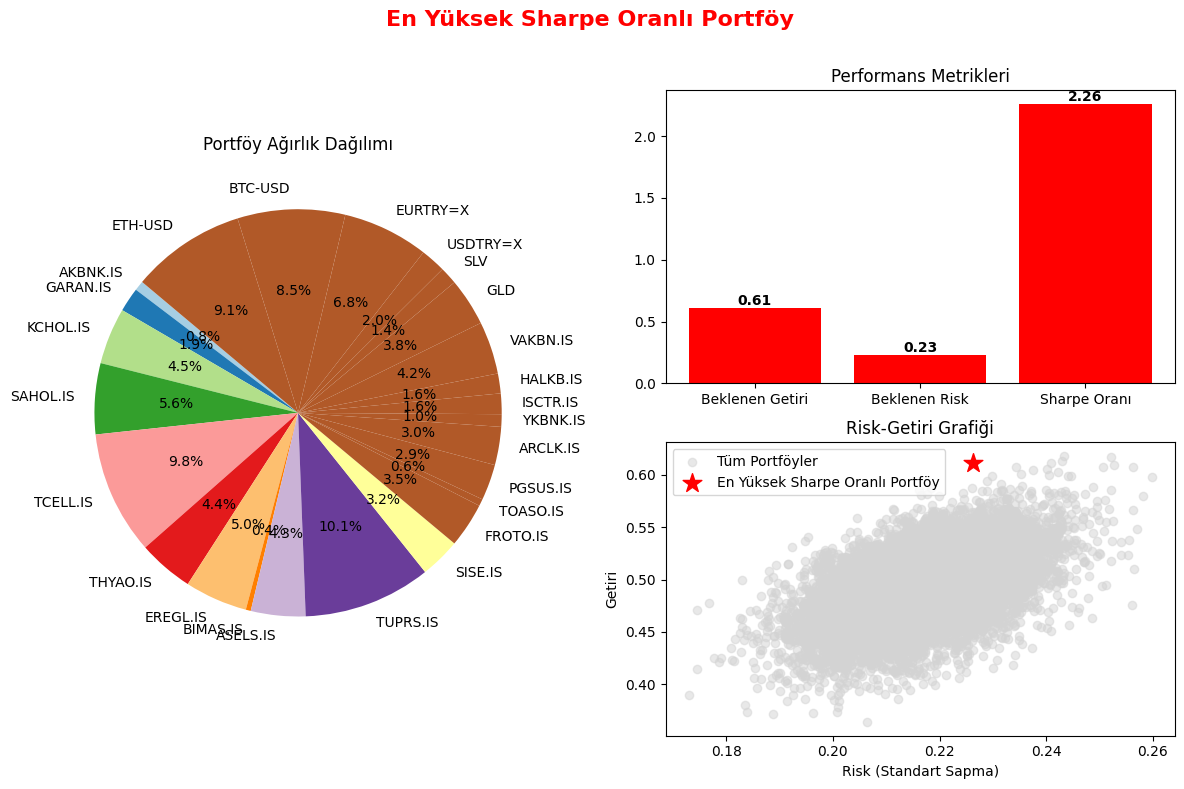

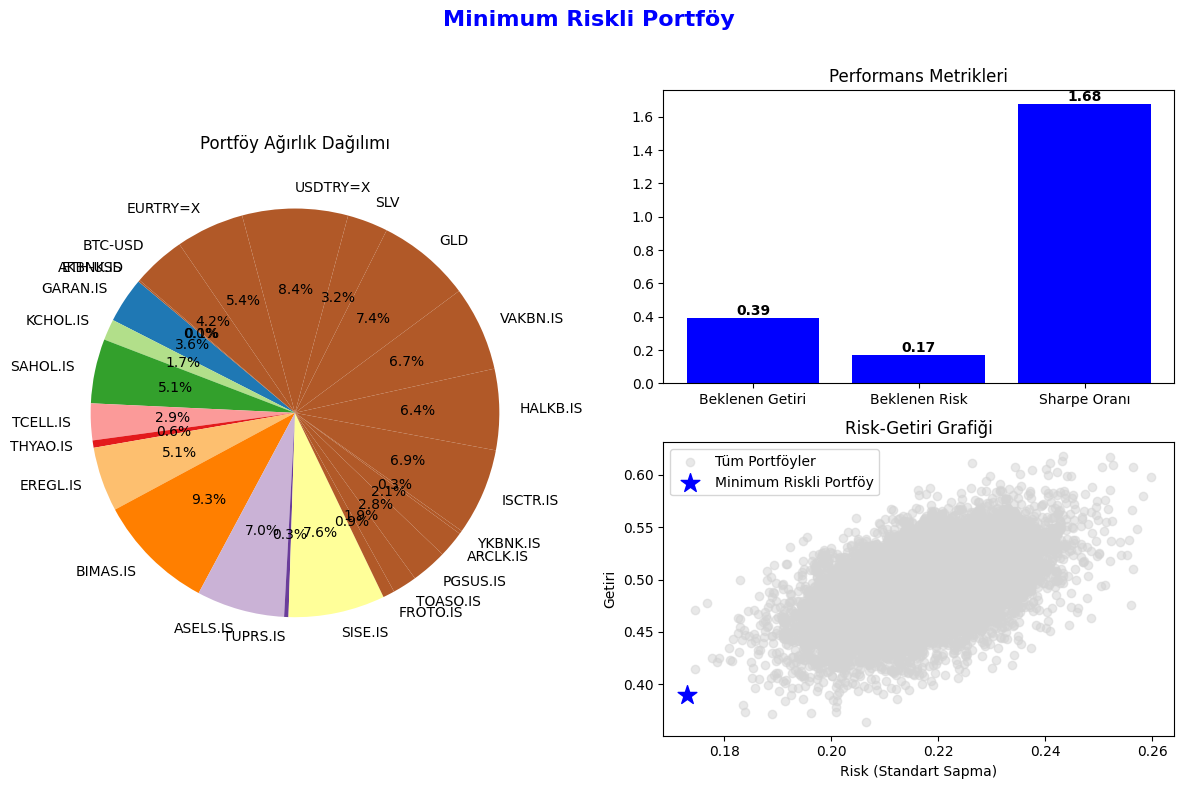

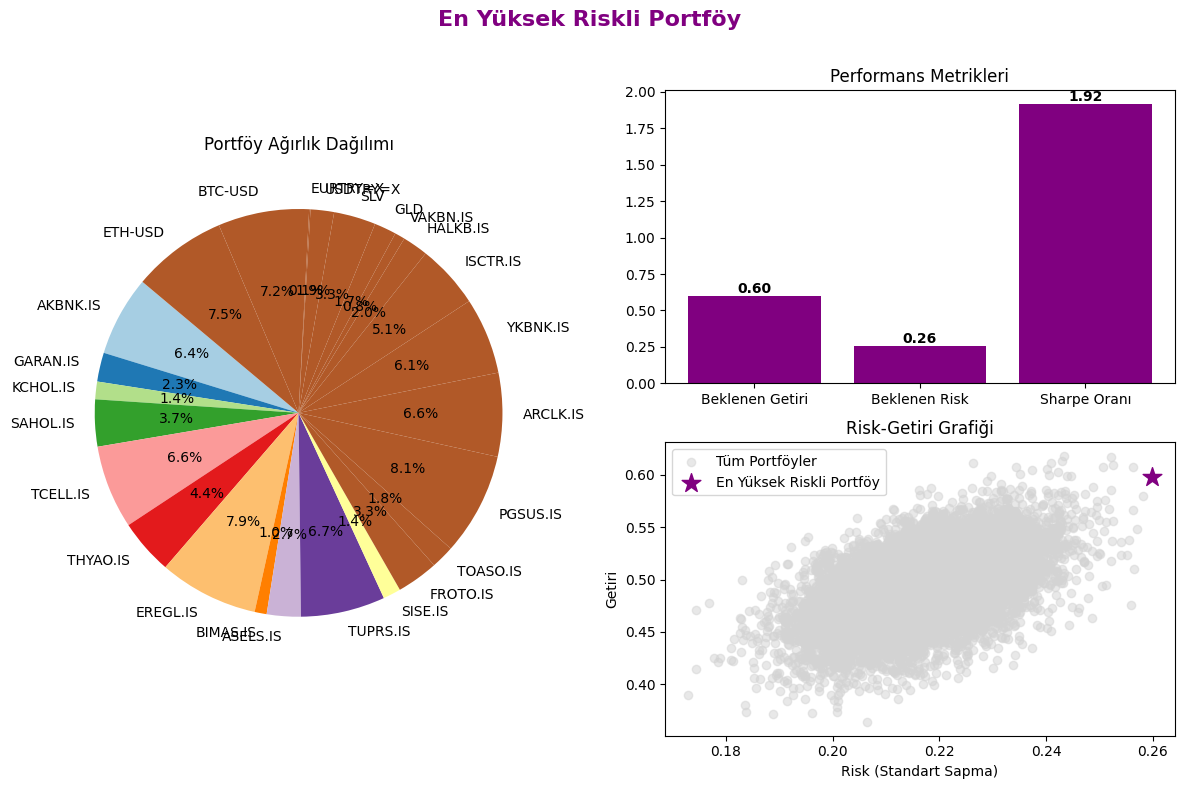

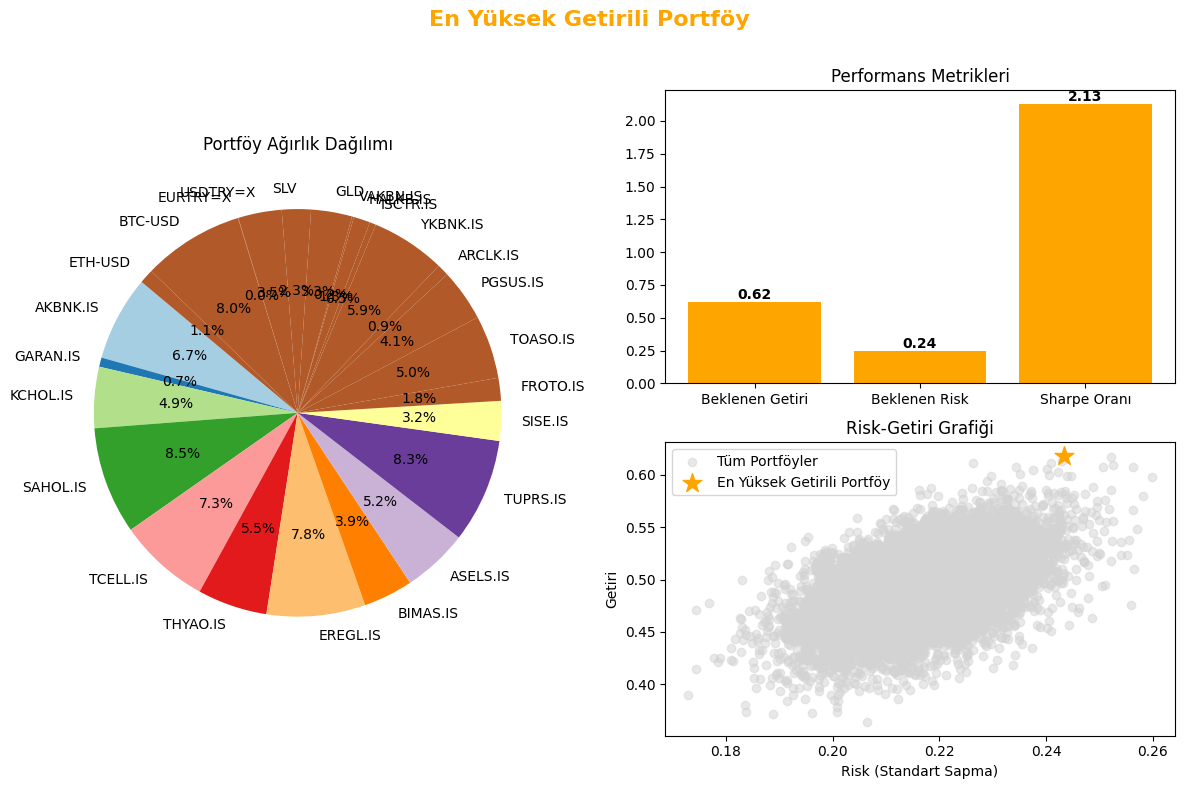

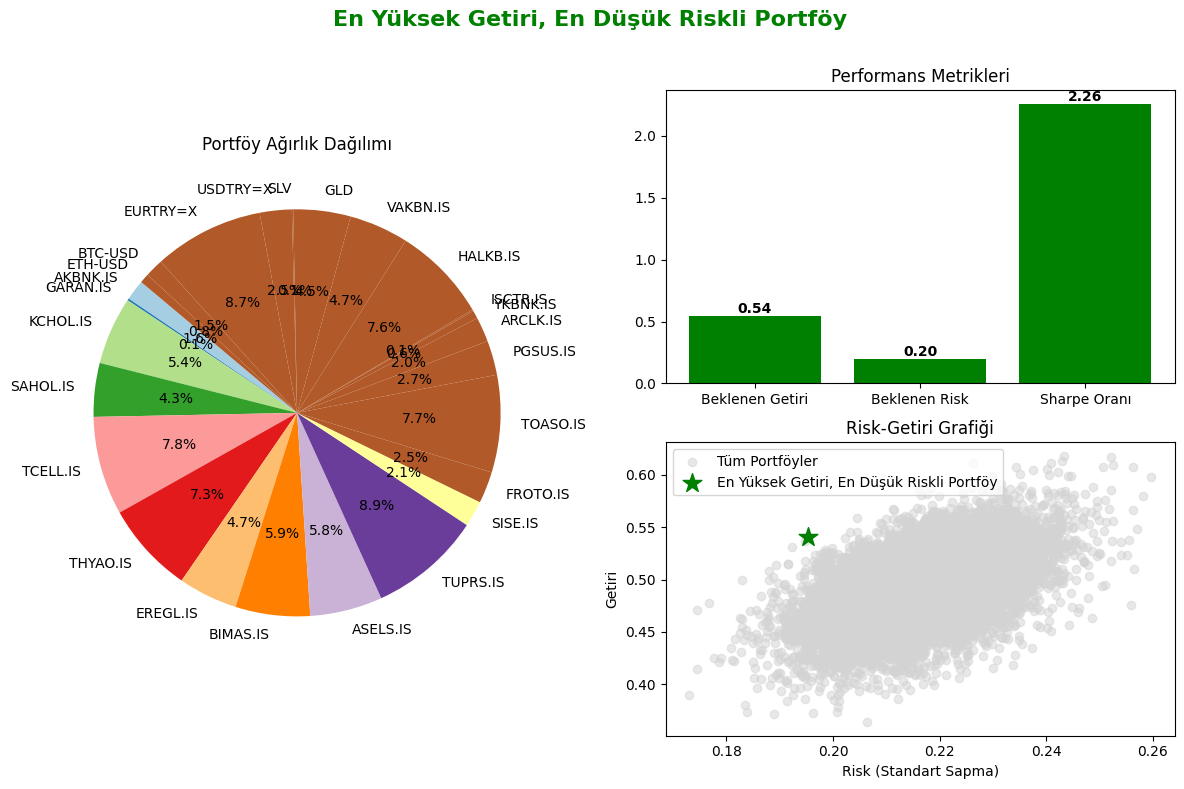

In [62]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

# Portföyleri ve performanslarını tutacak yapı
portfolios = {
    "En Yüksek Sharpe Oranlı Portföy": (max_sharpe_idx, "red"),
    "Minimum Riskli Portföy": (min_risk_idx, "blue"),
    "En Yüksek Riskli Portföy": (max_risk_idx, "purple"),
    "En Yüksek Getirili Portföy": (max_return_idx, "orange"),
    "En Yüksek Getiri, En Düşük Riskli Portföy": (max_return_low_risk_idx, "green")
}

# Fonksiyon: Performans Tablosu ve Grafik
def display_portfolio_summary(portfolio_name, idx, color):
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 2, figure=fig)  # 2x2 Grid
    fig.suptitle(f"{portfolio_name}", fontsize=16, fontweight="bold", color=color)

    # Portföy Ağırlıkları
    weights = weights_df.iloc[idx]
    metrics = results_df.iloc[idx]

    # 1. Ağırlık Dağılımı - Pasta Grafiği
    ax1 = fig.add_subplot(gs[:, 0])
    ax1.pie(weights, labels=weights.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(weights))))
    ax1.set_title("Portföy Ağırlık Dağılımı")

    # 2. Performans Metrikleri - Bar Grafiği
    ax2 = fig.add_subplot(gs[0, 1])
    metrics_data = [metrics['Return'], metrics['Risk'], metrics['Sharpe']]
    labels = ["Beklenen Getiri", "Beklenen Risk", "Sharpe Oranı"]
    ax2.bar(labels, metrics_data, color=color)
    ax2.set_title("Performans Metrikleri")
    for i, value in enumerate(metrics_data):
        ax2.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10, fontweight="bold")

    # 3. Risk-Getiri Noktası (Tek Nokta)
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(results_df['Risk'], results_df['Return'], c='lightgray', alpha=0.5, label="Tüm Portföyler")
    ax3.scatter(metrics['Risk'], metrics['Return'], color=color, s=200, marker="*", label=portfolio_name)
    ax3.set_title("Risk-Getiri Grafiği")
    ax3.set_xlabel("Risk (Standart Sapma)")
    ax3.set_ylabel("Getiri")
    ax3.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Tüm Portföyleri Görselleştir
for name, (idx, color) in portfolios.items():
    display_portfolio_summary(name, idx, color)


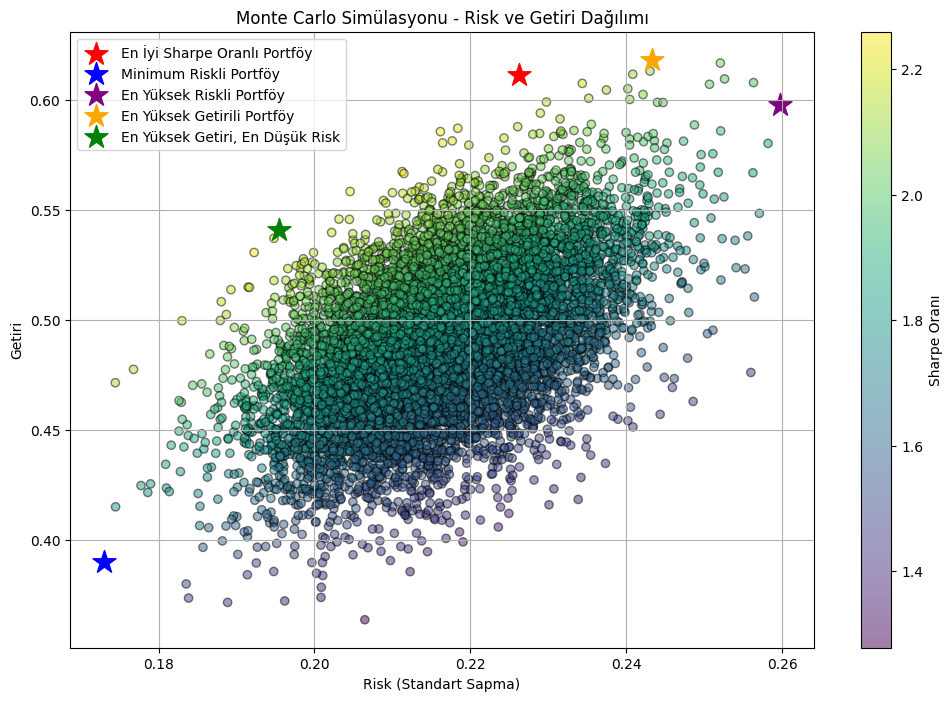

### Portföy Metrikleri ###

En Yüksek Sharpe Oranlı Portföy:
Return    0.611290
Risk      0.226233
Sharpe    2.260012
Name: 1068, dtype: float64

Minimum Riskli Portföy:
Return    0.390090
Risk      0.172972
Sharpe    1.677092
Name: 9428, dtype: float64

En Yüksek Riskli Portföy:
Return    0.597759
Risk      0.259758
Sharpe    1.916242
Name: 9212, dtype: float64

En Yüksek Getirili Portföy:
Return    0.618127
Risk      0.243340
Sharpe    2.129225
Name: 8155, dtype: float64

En Yüksek Getiri, En Düşük Risk Portföyü:
Return    0.540965
Risk      0.195389
Sharpe    2.256851
Name: 9905, dtype: float64


In [57]:
# Risk-Getiri Grafiği
plt.figure(figsize=(12, 8))

# Tüm portföyler
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', alpha=0.5, edgecolors="k")
plt.colorbar(label='Sharpe Oranı')

# En yüksek Sharpe oranına sahip portföy
max_sharpe_idx = results_df['Sharpe'].idxmax()
plt.scatter(results_df.iloc[max_sharpe_idx]['Risk'], results_df.iloc[max_sharpe_idx]['Return'],
            color='red', marker='*', s=300, label='En İyi Sharpe Oranlı Portföy')

# Minimum riskli portföy
min_risk_idx = results_df['Risk'].idxmin()
plt.scatter(results_df.iloc[min_risk_idx]['Risk'], results_df.iloc[min_risk_idx]['Return'],
            color='blue', marker='*', s=300, label='Minimum Riskli Portföy')

# En yüksek risk, en yüksek getiri portföyü
max_risk_idx = results_df['Risk'].idxmax()
plt.scatter(results_df.iloc[max_risk_idx]['Risk'], results_df.iloc[max_risk_idx]['Return'],
            color='purple', marker='*', s=300, label='En Yüksek Riskli Portföy')

# En yüksek kazanç portföyü (getirisi en büyük)
max_return_idx = results_df['Return'].idxmax()
plt.scatter(results_df.iloc[max_return_idx]['Risk'], results_df.iloc[max_return_idx]['Return'],
            color='orange', marker='*', s=300, label='En Yüksek Getirili Portföy')

# En yüksek kazanç, en düşük risk portföyü (getiri/risk oranı maksimize edilmiş)
max_return_low_risk_idx = (results_df['Return'] / results_df['Risk']).idxmax()
plt.scatter(results_df.iloc[max_return_low_risk_idx]['Risk'], results_df.iloc[max_return_low_risk_idx]['Return'],
            color='green', marker='*', s=300, label='En Yüksek Getiri, En Düşük Risk')

# Grafik detayları
plt.title('Monte Carlo Simülasyonu - Risk ve Getiri Dağılımı')
plt.xlabel('Risk (Standart Sapma)')
plt.ylabel('Getiri')
plt.legend()
plt.grid(True)
plt.show()

# Portföy detaylarını yazdırma
print("### Portföy Metrikleri ###")
print("\nEn Yüksek Sharpe Oranlı Portföy:")
print(results_df.iloc[max_sharpe_idx])

print("\nMinimum Riskli Portföy:")
print(results_df.iloc[min_risk_idx])

print("\nEn Yüksek Riskli Portföy:")
print(results_df.iloc[max_risk_idx])

print("\nEn Yüksek Getirili Portföy:")
print(results_df.iloc[max_return_idx])

print("\nEn Yüksek Getiri, En Düşük Risk Portföyü:")
print(results_df.iloc[max_return_low_risk_idx])
